# LangChain to Query PDF files: Task

This notebook demonstrates the task to use `langchain` to create a workflow for retrieving and pdf text data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1y57vZOOZMQFoJ_H7hog02Kq-dNCGpSBP?usp=sharing)

## Installation

First, we need to install the necessary packages:

In [ ]:
# Install required packages
!pip install -qU langchain langchain-openai openai langchain_community sentence_transformers tiktoken pydantic docarray chromadb==0.4.24 pypdf lark
!pip install -qU faiss-cpu #faiss-gpu For CUDA 7.5+ Supported GPU's.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
!pip freeze | grep "lang\|openai\|chroma"

chroma-hnswlib==0.7.3
chromadb==0.4.24
google-ai-generativelanguage==0.6.4
google-cloud-language==2.13.3
langchain==0.2.1
langchain-community==0.2.1
langchain-core==0.2.3
langchain-openai==0.1.8
langchain-text-splitters==0.2.0
langcodes==3.4.0
langsmith==0.1.69
language_data==1.2.0
libclang==18.1.1
openai==1.31.0


#### Setting Up the OpenAI API Key
First, we set up the OpenAI API key for our application. This is necessary for accessing various OpenAI services, including the language models. If you're running this in Google Colab, it will attempt to use the API key stored in your Colab environment; otherwise, it falls back to a default value you can replace.


In [ ]:
# Set OpenAI API key from Google Colab's user environment or default
def set_openai_api_key(default_key: str = "YOUR_API_KEY") -> None:
    """Set the OpenAI API key from Google Colab's user environment or use a default value."""
    from google.colab import userdata
    import os

    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY") or default_key


set_openai_api_key()

## Vectorstores

Vectorstores are used for efficient storage and retrieval of text embeddings. You are free to choose any vector store to perform similarity searches.

Chroma is recomended to start with

In [ ]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.vectorstores import Chroma
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
persist_directory = "db/chroma/"

In [ ]:
!rm -rf ./db/chroma  # removing other db files! Be careful!

## Utility functions

Below are some utility functions to comple the task easier

In [ ]:
# You can load the pdf files using the followin rows:

# pdf_url = "link/to/pdf"
# pdf_filename = "some_pdf_name.pdf"
# pdf_document = load_document_from_url(pdf_url, "some_pdf_name.pdf", SOME_PDF_LOADER)

import requests

# Example of loading and using document loaders
def load_document_from_url(url: str, filename: str, loader_class):
    """Download a document from a URL, save it, and load it using a specified loader class.

    Args:
        url: URL of the document to download.
        filename: Filename to save the downloaded document.
        loader_class: The class of loader to use for loading the document.

    Returns:
        The loaded document.
    """
    download_and_save_file(url, filename)
    loader = loader_class(filename)
    return loader.load()


def download_and_save_file(url: str, filename: str) -> None:
    """Download file from a URL and save it locally.

    Args:
        url: The URL of the file to download.
        filename: The local filename to save the downloaded content.
    """
    response = requests.get(url)
    response.raise_for_status()  # Raises HTTPError for bad responses
    with open(filename, "wb") as file:
        file.write(response.content)

In [ ]:
# Utility functions

# You can load display the similarity search results

def display_similarity_search_results(docs, excerpt_length=200):
    """
    Displays results from a similarity search.

    This function checks the structure of the documents to determine how to display them.
    If a document includes a score, it prints both the document content (truncated to `excerpt_length`) and its score.
    Otherwise, it prints the document content and metadata.

    Args:
        docs: A list of documents from a similarity search. Each document can either be a tuple with
              (document, score) format or a single document object.
        excerpt_length: The maximum length of the document content to display.
    """
    for doc in docs:
        if isinstance(doc, tuple):
            # Handle case with document and score
            doc, score = doc[0], doc[1]
        else:
            # Handle case without score, directly accessing the document
            score = None

        print(f"doc: {doc.page_content[:excerpt_length]}")
        print(f"metadata: {doc.metadata}")
        print(f"score: {score}" if score else "")
        print("-" * 30)

## Task

Your task will be to build a Retriever-Augmented Generation (RAG) pipeline, combining retrieved relevant documents and generating responses based on those documents.

There will be a couple of questions that your application will need to answer


In [ ]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)
openai_embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
question_1 = "What is the fine for driving in the bus lane?"

Upload the file

In [ ]:
pdf_url = "https://raw.githubusercontent.com/IvanReznikov/The-Generative-AI-with-LangChain/main/data/pdf/appecodicestrada.pdf"
pdf_filename = "rule_updates.pdf"

In [ ]:
pdf_document = load_document_from_url(pdf_url, "rule_updates.pdf", PyPDFLoader)

The uploaded above file contains information regarding the updated rules to drive in Italy

1. Split the data to chunks as you find most necessary (https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/)

```
pdf_splitter = RecursiveCharacterTextSplitter(
    separators=..., chunk_size=..., chunk_overlap=..., keep_separator=...
)
chunks = pdf_splitter.split_documents(pdf_document)
```

In [ ]:
pdf_splitter = RecursiveCharacterTextSplitter(
    separators=["\n"], chunk_size=500, chunk_overlap=100, keep_separator=False
)
chunks = pdf_splitter.split_documents(pdf_document)

In [ ]:
chunks[0]

Document(page_content='TUTTE LE MODIFICHE AL CODICE DELLA STRADA (*)  \n \n(*) Le modifiche apportate dal Dl 76/2020, convertito con modificazioni dalla legge 120/2020, sono \nevidenziate in nero.  \n \nArticolo 2   \n(Definizione e classificazione delle strade)  \n1. Ai fini dell\'applicazione delle norme del presente codice si definisce "strada" l\'area ad uso pubblico \ndestinata alla circolazione dei pedoni, dei veicoli e degli animali.', metadata={'source': 'rule_updates.pdf', 'page': 0})

2. Upload data to Chroma

```
chroma_db = Chroma.from_documents(
    documents=some_chunks, embedding=some_embedding_model, persist_directory=persist_directory
)
```

In [ ]:
chroma_db = Chroma.from_documents(
    documents=chunks, embedding=openai_embedding, persist_directory=persist_directory
)

3. Display the closest results related to `question_1`. If the results aren't satisfying, you may consider changing one of the previous steps

`docs = chroma_db.similarity_search_with_score(question_1, k=3)`

Use the `display_similarity_search_results(docs)` to display the results

In [ ]:
docs = chroma_db.similarity_search_with_score(question_1, k=3)
display_similarity_search_results(docs)

doc: sanzione amministrativa del pagamento di una somma da Euro 42,00 a Euro 173,00. La violazione del 
divieto di circolazione nelle corsie riservate ai mezzi pubblici di trasporto, nelle aree pedonali e 
metadata: {'page': 8, 'source': 'rule_updates.pdf'}
score: 0.9602651000022888
------------------------------
doc: pagamento di una somma da euro 167,00 a euro 666,00.  
11. Quando lo stesso soggetto sia incorso, in un periodo di due anni, in una delle violazioni di cui al comma 
10 per almeno due volte, all'ultim
metadata: {'page': 19, 'source': 'rule_updates.pdf'}
score: 1.1416693925857544
------------------------------
doc: pagamento di una somma da euro 26,00 a euro 102,00. La sanzione è da euro 42,00 a euro 173,00 quando 
si tratta di velocipedi di cu i al comma 6.  
 
Articolo 201  
(Notificazione delle violazioni)  

metadata: {'page': 25, 'source': 'rule_updates.pdf'}
score: 1.1514800586081162
------------------------------


4. Use the RAG pipeline and query it using `rag_chain.invoke(question_1)`

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

def setup_rag(**kwargs):
    retriever = chroma_db.as_retriever(**kwargs)
    setup_and_retrieval = RunnableParallel(
        {"context": retriever, "question": RunnablePassthrough()}
    )

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    output_parser = StrOutputParser()

    rag_chain = setup_and_retrieval | prompt | llm | output_parser
    return rag_chain

In [ ]:
rag_chain = setup_rag()

In [ ]:
rag_chain.invoke(question_1)

'The fine for driving in the bus lane is from €83.00 to €333.00.'

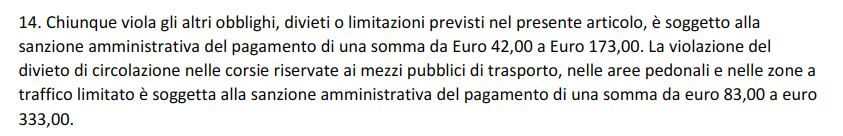

In [ ]:
question_2 = "What should the driver do before overtaking?"

In [ ]:
docs = chroma_db.similarity_search_with_score(question_2, k=3)
display_similarity_search_results(docs)

doc: tenendosi da questo ad una adeguata distanza laterale e riportarsi a destra appena possibile, senza creare 
pericolo o intralcio. Se la carreggiata o semicarreggiata sono suddivise in più corsie, il s
metadata: {'page': 19, 'source': 'rule_updates.pdf'}
score: 1.050602912902832
------------------------------
doc: o intralcio;  
b) che il conducente che lo precede nella stessa corsia non abbia segnalato di voler compiere analoga 
manovra;  
c) che nessun conducente che segue sulla stessa carreggiata o semicarre
metadata: {'page': 19, 'source': 'rule_updates.pdf'}
score: 1.0637946128845215
------------------------------
doc: anche conto della differenza tra la propria velocità e quella dell'utente da sorpassare, nonché della 
presenza di utenti che sopraggiungono dalla direzione contraria o che precedono l'utente da sorpa
metadata: {'page': 19, 'source': 'rule_updates.pdf'}
score: 1.0803749561309814
------------------------------


In [ ]:
rag_chain.invoke(question_2)

'Before overtaking, the driver should:\n\n1. Ensure that the driver ahead in the same lane has not signaled an intention to overtake.\n2. Confirm that no driver following in the same lane or in the lane immediately to the left has started overtaking.\n3. Verify that the road is clear for a sufficient distance to complete the overtaking maneuver safely, considering the speed difference between their vehicle and the one to be overtaken, as well as the presence of oncoming traffic or other users ahead of the vehicle to be overtaken.'

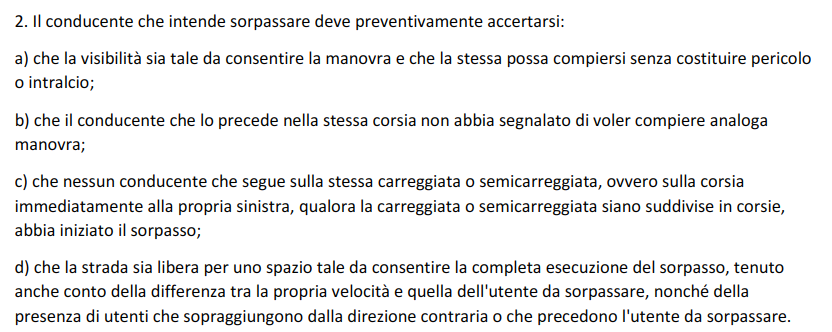

## Advanced retrieval operations

`Maximum marginal relevance` or `MMR` strives to achieve both relevance to the query and diversity among the results. We setup `k` as the number of documents we want to get and `fetch_k` as the amount of documents to choose from.

Let's look closely how the pages of chunks changed, compared to the previous result - compare pages and fragements of documents.

use `chroma_db.max_marginal_relevance_search(your_question, k=3, fetch_k=10)`



In [ ]:
docs = chroma_db.max_marginal_relevance_search(question_2, k=3, fetch_k=10)
display_similarity_search_results(docs)

doc: tenendosi da questo ad una adeguata distanza laterale e riportarsi a destra appena possibile, senza creare 
pericolo o intralcio. Se la carreggiata o semicarreggiata sono suddivise in più corsie, il s
metadata: {'page': 19, 'source': 'rule_updates.pdf'}

------------------------------
doc: sicurezza in considerazione della minore stab ilità e della probabilità di ondeggiamenti e deviazioni da 
parte del velocipede stesso. Prima di effettuare il sorpasso di un velocipede, il conducente 

metadata: {'page': 20, 'source': 'rule_updates.pdf'}

------------------------------
doc: rallentare e, se necessario, metter si da parte appena possibile, per lasciar passare i veicoli che seguono. Nei 
centri abitati non sono tenuti all'osservanza di quest'ultima disposizione i conducent
metadata: {'page': 19, 'source': 'rule_updates.pdf'}

------------------------------


To incorporate in your setup_rag pipeline, use search_type="mmr", fetch_k=10 parameters

In [ ]:
rag_chain = setup_rag(search_type="mmr", fetch_k=10)

In [ ]:
rag_chain.invoke(question_2)

'Before overtaking, the driver should evaluate the existence of conditions that allow for the maneuver to be completed in complete safety for both vehicles, and reduce speed particularly if necessary.'

## Filtering documents

So far we had only 1 document. But usually you may have much more files in the database. You can implement filtering documents by metadata (source, page, etc)

In [ ]:
print(chroma_db._collection.count())

251


In [ ]:
pdf_url = "https://raw.githubusercontent.com/IvanReznikov/The-Generative-AI-with-LangChain/main/data/pdf/settestrade-dicembre-2017.pdf"
pdf_filename = "settestrade.pdf"

In [ ]:
pdf_document = load_document_from_url(pdf_url, "settestrade.pdf", PyPDFLoader)

Don't forget to split the data to chunks and upload to Chroma!

In [ ]:
pdf_splitter = RecursiveCharacterTextSplitter(
    separators=["\n"], chunk_size=500, chunk_overlap=100, keep_separator=False
)
chunks = pdf_splitter.split_documents(pdf_document)

In [ ]:
chroma_db = Chroma.from_documents(
    documents=chunks, embedding=openai_embedding, persist_directory=persist_directory
)

In [ ]:
pdf_url = "https://raw.githubusercontent.com/IvanReznikov/The-Generative-AI-with-LangChain/main/data/pdf/codice_010910.pdf"
pdf_filename = "codice_010910.pdf"

In [ ]:
pdf_document = load_document_from_url(pdf_url, "codice_010910.pdf", PyPDFLoader)

In [ ]:
pdf_splitter = RecursiveCharacterTextSplitter(
    separators=["\n"], chunk_size=500, chunk_overlap=100, keep_separator=False
)
chunks = pdf_splitter.split_documents(pdf_document)

In [ ]:
chroma_db = Chroma.from_documents(
    documents=chunks, embedding=openai_embedding, persist_directory=persist_directory
)

In [ ]:
print(chroma_db._collection.count())

2626


Let's view how our first question is similar to chunks found in all documents uploaded to vector store.

In [ ]:
docs = chroma_db.similarity_search(question_1, k=5)
display_similarity_search_results(docs)

doc: sanzione amministrativa del pagamento di una somma da Euro 42,00 a Euro 173,00. La violazione del 
divieto di circolazione nelle corsie riservate ai mezzi pubblici di trasporto, nelle aree pedonali e 
metadata: {'page': 8, 'source': 'rule_updates.pdf'}

------------------------------
doc: alla sanzione amministrativa del pagamento di una somma da euro 38 a euro 155. La violazione del 
divieto di circolazione nelle corsie riservate ai mezzi pubblici di trasporto, nelle aree pedonali e 

metadata: {'page': 12, 'source': 'codice_010910.pdf'}

------------------------------
doc: amministrativa del pagamento di una somma da euro 78 a euro 311. (4) 
14. Chiunque viola gli altri obblighi, divieti o limi tazioni previsti nel presente articolo, è soggetto alla sanzione 
amministra
metadata: {'page': 14, 'source': 'codice_010910.pdf'}

------------------------------
doc: è del pagamento di una somma da euro 23 a euro 92.  
11. Chiunque viola le altre disposizioni del presente articolo è sog

Now lets use `filter={"source":"filename_1.pdf"}` in `chroma_db.similarity_search`

In [ ]:
docs = chroma_db.similarity_search(
    question_1,
    k=5,
    filter={"source":"rule_updates.pdf"}
)
display_similarity_search_results(docs)

doc: sanzione amministrativa del pagamento di una somma da Euro 42,00 a Euro 173,00. La violazione del 
divieto di circolazione nelle corsie riservate ai mezzi pubblici di trasporto, nelle aree pedonali e 
metadata: {'page': 8, 'source': 'rule_updates.pdf'}

------------------------------
doc: pagamento di una somma da euro 167,00 a euro 666,00.  
11. Quando lo stesso soggetto sia incorso, in un periodo di due anni, in una delle violazioni di cui al comma 
10 per almeno due volte, all'ultim
metadata: {'page': 19, 'source': 'rule_updates.pdf'}

------------------------------
doc: pagamento di una somma da euro 26,00 a euro 102,00. La sanzione è da euro 42,00 a euro 173,00 quando 
si tratta di velocipedi di cu i al comma 6.  
 
Articolo 201  
(Notificazione delle violazioni)  

metadata: {'page': 25, 'source': 'rule_updates.pdf'}

------------------------------
doc: amministrativa pecuniaria è applicata pe r ogni periodo di ventiquattro ore, per il quale si protrae la 
violazione. Se si 

You can use the same filter in our RAG pipeline, as `filter={"source":"filename_1.pdf"}` parameter. Check how the filter works for several documents

In [ ]:
rag_chain = setup_rag(filter={"source":"rule_updates.pdf"}, k=3)

In [ ]:
rag_chain.invoke(question_1)

'The fine for driving in the bus lane is a payment of a sum ranging from euro 83,00 to euro 333,00.'

In [ ]:
rag_chain = setup_rag(filter={"source":"codice_010910.pdf"}, k=3)

In [ ]:
rag_chain.invoke(question_1)

'The fine for driving in the bus lane is subject to an administrative penalty ranging from €74 to €333.'

This look great, but there is a fancier way to use filtering using `SelfQueryRetriever` - the llm will understand what file to use based on names

In [ ]:
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The pdf document, for example, `rule_updates.pdf`, `codice_010910` or `settestrade.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the pdf document",
        type="integer",
    ),
]

In [ ]:
document_content_description = "Road-related pdf documents"
retriever = SelfQueryRetriever.from_llm(
    llm,
    chroma_db,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [ ]:
question_1_plus = question_1 + "from the updated rules document"

In [ ]:
docs = retriever.get_relevant_documents(question_1_plus)
display_similarity_search_results(docs)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


doc: sanzione amministrativa del pagamento di una somma da Euro 42,00 a Euro 173,00. La violazione del 
divieto di circolazione nelle corsie riservate ai mezzi pubblici di trasporto, nelle aree pedonali e 
metadata: {'page': 8, 'source': 'rule_updates.pdf'}

------------------------------
doc: sanz ione amministrativa pecuniaria.  
5. L'obbligo di pagare la somma dovuta per la violazione, a titolo di sanzione amministrativa pecuniaria, si 
estingue nei confronti del soggetto a cui la notifi
metadata: {'page': 27, 'source': 'rule_updates.pdf'}

------------------------------
doc: pagamento di una somma da euro 167,00 a euro 666,00.  
11. Quando lo stesso soggetto sia incorso, in un periodo di due anni, in una delle violazioni di cui al comma 
10 per almeno due volte, all'ultim
metadata: {'page': 19, 'source': 'rule_updates.pdf'}

------------------------------
doc: pagamento di una somma da euro 42,00 a euro 173,00. Se la violazione riguarda le disposizioni di cui al 
comma 6 la sanzion